# Harnessing the Power of Geophysical Imaging for Recharging California's Groundwatere

In [ ]:
from emrecharge.datasets import EMDataset
from discretize.utils import volume_average
import numpy as np
import geopandas as gpd
import dill
import matplotlib.pyplot as plt
from discretize import TensorMesh
from scipy.spatial import cKDTree as kdtree
from SimPEG.utils import rotate_points_from_normals
from SimPEG import utils
from verde import distance_mask
import pandas as pd
import numpy.ma as ma
from matplotlib.colors import LogNorm
from emrecharge.colocation import find_locations_in_distance
from SimPEG.utils import rotate_points_from_normals
import dill
from scipy.interpolate import NearestNDInterpolator
from discretize import TensorMesh
from discretize.utils import mesh_builder_xyz
import geopandas as gpd
import matplotlib


def rotate_vector(xy, invert=False):
    x0_max = 128989.96617666919
    y0_min = -344621.31282856315
    if invert:
        xy_norm = np.c_[xy[:,0], xy[:,1], np.zeros_like(xy[:,0])]
        xy_norm_rot = rotate_points_from_normals(xy_norm, np.array([0,1,0]), np.array([-352306.81278939766, 643151.2476351159,0]))
        xy_norm_rot[:,0] += x0_max
        xy_norm_rot[:,1] += y0_min
    else:
        xy_norm = np.c_[xy[:,0]-x0_max, xy[:,1]-y0_min, np.zeros_like(xy[:,0])]
        xy_norm_rot = rotate_points_from_normals(xy_norm, np.array([-352306.81278939766, 643151.2476351159,0]), np.array([0,1,0]))
    return xy_norm_rot[:,:2]

## Load AEM resistivity data

In [ ]:
gdf_cv = gpd.read_file("../data/shp/cv/cv.shp")
gdf_cv_3310 = gdf_cv.to_crs(3310)
SPATIAL_UNIT = 'm'
em_data = EMDataset(
    "../data/aem/em_resistivity.csv",
    "../data/aem/thickness.csv",
    SPATIAL_UNIT
)

## Select resistivity values, and rotate xy points

In [184]:
hz_aem = em_data.hz
hz_uniform = np.ones(60)*2.
mesh_1d_aem = TensorMesh([hz_aem])
mesh_1d_uniform = TensorMesh([hz_uniform])
P_1d = mesh_1d_aem.get_interpolation_matrix(mesh_1d_uniform.cell_centers)
inds_aem_active = np.load("../data/inds_active_aem.npy")
RHO = em_data.resistivity
xy_aem = em_data.xy
RHO_ACTIVE = RHO[inds_aem_active,:]
xy_aem_active = xy_aem[inds_aem_active,:]
xy_aem_rot = rotate_vector(xy_aem)
xy_aem_active_rot = rotate_vector(xy_aem_active)

## Load rock physics relationship between resistivity and sediment type

In [ ]:
results_rock_physics_grid = dill.load(open("../data/rock_physics_grid.pik", "rb"))
mesh = results_rock_physics_grid['mesh']
mesh_coarse = results_rock_physics_grid['mesh_coarse']
rho_fine_cv_grid_idw = results_rock_physics_grid['rho_fine_cv_grid_idw']
rho_coarse_cv_grid_idw = results_rock_physics_grid['rho_coarse_cv_grid_idw']
wt_idw = results_rock_physics_grid['wt_idw']
xy_grid_coarse_rot = results_rock_physics_grid['xy_grid_coarse_rot']

In [ ]:
f_rho_fine = NearestNDInterpolator(mesh_coarse.cell_centers, rho_fine_cv_grid_idw)
f_rho_coarse = NearestNDInterpolator(mesh_coarse.cell_centers, rho_coarse_cv_grid_idw)
rho_fine_cv_mesh = f_rho_fine(mesh.cell_centers)
rho_coarse_cv_mesh = f_rho_coarse(mesh.cell_centers)
rho_fine_cv_aem = f_rho_fine(xy_aem_rot)
rho_coarse_cv_aem = f_rho_coarse(xy_aem_rot)

## Define the region of interest

In [53]:
df_bedrock = pd.read_csv("../data/bedrock_depth_int.csv")
gdf_bedrock_boundary= gpd.read_file('../data/shp/bedrock_boundary')
xy_bedrock_int = df_bedrock[['UTMX', 'UTMY']].values

In [54]:
# Set the grid cell size to be 400 m x 400 m
mesh_orig = mesh_builder_xyz(xy_aem[:,:2], [400, 400], padding_distance=[[4000, 4000], [4000, 4000]], expansion_factor=1)
# mesh_orig.write_UBC('mesh_orig.msh')
xy_grid = mesh.cell_centers
xy_grid_orig = mesh_orig.cell_centers
xy_grid_rot = rotate_vector(xy_grid, invert=True)
xy_bedrock_int_rot = rotate_vector(xy_bedrock_int, invert=False)

In [55]:
# Water table
f_gse_wse = NearestNDInterpolator(xy_grid_rot, wt_idw.data)
depth_aem_center = mesh_1d_aem.cell_centers
# Bedrock depth
f_bedrock = NearestNDInterpolator(xy_bedrock_int, df_bedrock['BEDROCK_DEPTH_M'].values)

In [56]:
geoms_pts_orig = gpd.points_from_xy(xy_grid_orig[:,0], xy_grid_orig[:,1])
gdf_grid_orig = gpd.GeoDataFrame(data={}, geometry=geoms_pts_orig, crs=3310)
gdf_grid_orig_clip = gdf_grid_orig.clip(gdf_bedrock_boundary)
inds_bedrock = np.array(list(gdf_grid_orig_clip.index))
base_int_orig = f_gse_wse(xy_grid_orig)
values_bedrock = f_bedrock(xy_grid_orig[inds_bedrock,:])
base_int_orig[inds_bedrock] = values_bedrock
f_base = NearestNDInterpolator(xy_grid_orig, base_int_orig)
base_int = f_base(xy_grid_rot)
base_int = np.clip(base_int, 3, 110)
base_int = ma.masked_array(base_int, mask=wt_idw.mask)

## Create base surface

In [62]:
xy_grid = mesh.cell_centers
tree = kdtree(xy_aem_rot)
k_nearest_points = 100
d, inds_idw = tree.query(xy_grid, k=int(k_nearest_points))
dx, dy = 400, 400
epsilon = np.min([dx, dy])
power = 1.
w = 1.0 / ((d + epsilon) ** power)
mask_inds = ~distance_mask(
    (xy_aem_rot[:, 0], xy_aem_rot[:, 1]),
    maxdist=3000,
    coordinates=(xy_grid[:,0], xy_grid[:,1]),
)

In [63]:
tree = kdtree(xy_aem_active_rot)
k_nearest_points = 100
d_active, inds_idw_active = tree.query(xy_grid, k=int(k_nearest_points))
dx, dy = 400, 400
epsilon = np.min([dx, dy])
power = 1.
w_active = 1.0 / ((d_active + epsilon) ** power)
mask_inds__active = ~distance_mask(
    (xy_aem_active_rot[:, 0], xy_aem_active_rot[:, 1]),
    maxdist=3000,
    coordinates=(xy_grid[:,0], xy_grid[:,1]),
)

In [64]:
tree = kdtree(xy_grid)
k_nearest_points = 100
d_grid, inds_idw_grid = tree.query(xy_grid, k=int(k_nearest_points))
dx, dy = 400, 400
epsilon = np.min([dx, dy])
power = 0.
w_grid = 1.0 / ((d_grid + epsilon) ** power)

In [65]:
values = base_int.data.copy()
base_int_idw = np.sum(w_grid * values[inds_idw_grid], axis=1) / np.sum(w_grid, axis=1)
base_aem = f_base(xy_aem)

In [66]:
Z = np.tile(depth_aem_center, (em_data.num_soundings, 1))
Z_base = np.tile(base_aem, (30, 1)).T
HZ = np.tile(hz_aem, (em_data.num_soundings, 1))
HZ[Z>Z_base] = 0.
RHO_ABOVE = RHO.copy()
SIGMA_ABOVE = 1./RHO_ABOVE
SIGMA_ABOVE[Z>Z_base] = 0.
RHO_ABOVE[Z>Z_base] = 0.
rho_avg = 1./((SIGMA_ABOVE * HZ).sum(axis=1) / HZ.sum(axis=1))
values = rho_avg.copy()
values_idw = np.sum(w * values[inds_idw], axis=1) / np.sum(w, axis=1)
values_idw = ma.masked_array(values_idw, mask=mask_inds)
rho_avg_idw = values_idw.copy()
# aem_rho_avg_dict = {'rho_avg':rho_avg, 'xy': xy_aem}
# dill.dump(aem_rho_avg_dict, open("aem_rho_avg_dict.pik", "wb"))

/var/folders/4m/sc07bkn154s8jfc7xp164by00000gq/T/ipykernel_42435/3239199944.py:9: RuntimeWarning: invalid value encountered in divide
  rho_avg = 1./((SIGMA_ABOVE * HZ).sum(axis=1) / HZ.sum(axis=1))


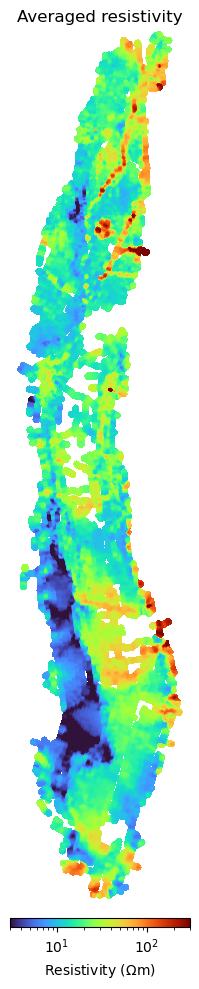

In [69]:
fig, ax = plt.subplots(1,1, figsize=(3, 10))
out = mesh.plot_image(rho_avg_idw, ax=ax, pcolor_opts={'norm':LogNorm(vmin=3, vmax=300), 'cmap':'turbo'})
ax.axis('off')

ax.set_aspect(1)
cb = plt.colorbar(out[0], orientation='horizontal', fraction=0.01, pad=0.02)
cb.set_label("Resistivity ($\Omega$m)")
ax.set_title("Averaged resistivity")
plt.tight_layout()
# fig.savefig('avg_rho.png', dpi=300)

## Create an interpolated 3D resistivity model

In [70]:
RHO_ABOVE_nan = RHO_ABOVE.copy()
RHO_ABOVE_nan[RHO_ABOVE==0.] = np.nan

In [ ]:
RHO_INT = np.zeros((mesh.n_cells, len(hz_aem)))
for i_layer in range(len(hz_aem)):
    values = RHO[:,i_layer].copy()
    values_idw = np.sum(w * values[inds_idw], axis=1) / np.sum(w, axis=1)
    values_idw = ma.masked_array(values_idw, mask=mask_inds__active)
    RHO_INT[:,i_layer] = values_idw
RHO_INT_uniform = RHO_INT * P_1d.T

In [72]:
# RHO_INT_uniform = 1./((1./RHO_INT) * P_1d.T)
# RHO_INT_uniform = RHO_INT * P_1d.T
Z3D = np.tile(mesh_1d_uniform.cell_centers, (mesh.n_cells, 1))
BASE3D = np.tile(base_int.data, (60, 1)).T
INDS3D = Z3D>BASE3D
# RHO_INT_uniform[INDS3D] = np.nan
# RHO_INT_uniform[mask_inds,:] = np.nan

In [73]:
base_inds_3d = INDS3D[:,::-1].copy()
base_inds_3d[mask_inds,:] = True
base_inds_3d = base_inds_3d.flatten(order='F')
mask_3d = np.tile(mask_inds__active, (60, 1))

base_inds_3d_active = INDS3D[:,::-1].copy()
base_inds_3d_active[mask_inds__active,:] = True
base_inds_3d_active = base_inds_3d.flatten(order='F')


mask_3d_final = np.logical_or(mask_3d.flatten(), base_inds_3d_active)

rho_int_uniform_simpeg = RHO_INT_uniform[:,::-1].flatten(order='F')
rho_int_uniform_simpeg = ma.masked_array(rho_int_uniform_simpeg, mask=mask_3d_final)

In [76]:
mesh_3d = TensorMesh([mesh.h[0], mesh.h[1], hz_uniform], x0=[mesh.x0[0], mesh.x0[1], -np.sum(hz_uniform)])

## Transform resistivity to CF

In [77]:
def from_sigma_to_fraction(sigma, sigma_fine, sigma_coarse):
    sigma_bounded = sigma.copy()
    sigma_bounded[sigma >= sigma_fine] = sigma_fine
    sigma_bounded[sigma <= sigma_coarse] = sigma_coarse
    fraction_coarse = (sigma_fine - sigma_bounded) / (sigma_fine - sigma_coarse)
    return fraction_coarse

In [78]:
SIGMA = 1./RHO.copy()

In [79]:
FCD = np.zeros_like(RHO_ABOVE)

In [80]:
nxy = 349*1773
nz = 60

In [81]:
SIGMA_3D = 1./rho_int_uniform_simpeg.data.reshape((nxy, nz), order='F')
FCD_3D = np.zeros_like(SIGMA_3D)

In [ ]:
for ii in range(nxy):
    FCD_3D[ii,:] = from_sigma_to_fraction(SIGMA_3D[ii,:], 1./rho_fine_cv_mesh[ii], 1./rho_coarse_cv_mesh[ii])
fcd_int_uniform_simpeg = ma.masked_array(FCD_3D.flatten(order='F'), mask=mask_3d_final)

## Create recharge metric maps

In [106]:
FCD3D = fcd_int_uniform_simpeg.data.reshape((nxy, nz), order='F')
HZ = np.ones_like(fcd_int_uniform_simpeg.data) * 2.
HZ[mask_3d_final] = 0.
HZ = HZ.reshape((nxy, nz), order='F')
tmp = (FCD3D*HZ).sum(axis=1) / (HZ).sum(axis=1)
tmp = ma.masked_array(tmp, mask=mask_inds__active)
fc_idw = ma.masked_array(tmp, mask=mask_inds__active)

/var/folders/4m/sc07bkn154s8jfc7xp164by00000gq/T/ipykernel_42435/2028783667.py:5: RuntimeWarning: invalid value encountered in divide
  tmp = (FCD3D*HZ).sum(axis=1) / (HZ).sum(axis=1)


In [ ]:
def calcluate_vertical_average(model, model_mask_3d, model_mask_2d, bottom, top, average_type='arithmetic'):
    nxy = 349*1773
    nz = 60
    ind_z = np.logical_and(mesh_3d.vectorCCz>-bottom, mesh_3d.vectorCCz<-top)
    MOD = model.reshape((nxy, nz), order='F')[:,ind_z]
    MASK = model_mask_3d.copy().reshape((nxy, nz), order='F')[:,ind_z]
    HZ = np.ones_like(MOD) * 2.
    HZ[MASK] = 0.
    HZ = HZ.reshape((nxy, ind_z.sum()), order='F')
    if average_type == 'arithmetic':
        avg = (MOD*HZ).sum(axis=1) / (HZ).sum(axis=1)
    elif average_type == 'harmonic':
        avg = 1./((1./MOD*HZ).sum(axis=1) / (HZ).sum(axis=1))
    else:
        raise Exception()
    avg = ma.masked_array(avg, mask=model_mask_2d)
    return avg

In [108]:
# mesh_3d.write_vtk('3d_models.vtr', models={'rho':rho_int_uniform_simpeg.data, 'mask': rho_int_uniform_simpeg.mask.astype(int), 'fcd':fcd_int_uniform_simpeg.data, 'mask_active': fcd_int_uniform_simpeg.mask.astype(int)})

In [ ]:
from emrecharge.metrics import (
    classify_cf,
    get_ready_for_fmm,
    run_fmm,
    get_distance_to_first_lowK
)

In [110]:
xyz_base = np.c_[xy_grid, base_int_idw]
mesh_fmm, inds_source = get_ready_for_fmm(mesh_3d, xyz_base)

In [111]:
xy_grid_fmm = utils.ndgrid(mesh_fmm.cell_centers_x, mesh_fmm.cell_centers_y)
gdf_basins_3310_cv = gpd.read_file("../data/shp/subbasins_cv_clip.geojson")
xy_grid_fmm_rot = rotate_vector(xy_grid_fmm, invert=True)

In [ ]:
# gdf_cv_3310_buffer = gdf_cv_3310.buffer(3000)
geoms = gpd.points_from_xy(xy_grid_rot[:,0], xy_grid_rot[:,1])
gdf_pts_grid_cv = gpd.GeoDataFrame(data={}, geometry=geoms, crs=3310)
gdf_pts_grid_clip_cv = gdf_pts_grid_cv.clip(gdf_cv_3310)
inds_active_cv = list(gdf_pts_grid_clip_cv.index)
inds_active_cv_bool = np.zeros(mesh.n_cells, dtype=bool)
inds_active_cv_bool[inds_active_cv] = True

In [113]:
# gdf_pts_grid_fmm_cv = gdf_pts_grid_fmm.clip(gdf_cv_3310)
# inds_active_fmm_cv = list(gdf_pts_grid_fmm_cv.index)
# inds_active_fmm_cv_bool = np.zeros(351*1775, dtype=bool)
# inds_active_fmm_cv_bool[inds_active_fmm_cv] = True

In [114]:
tree = kdtree(xy_grid_fmm_rot)
k_nearest_points = 100
d_active, inds_idw_active = tree.query(xy_grid, k=int(k_nearest_points))
dx, dy = 400, 400
epsilon = np.min([dx, dy])
power = 1.
w_active = 1.0 / ((d_active + epsilon) ** power)
mask_inds_active_fmm = ~distance_mask(
    (xy_aem_active_rot[:, 0], xy_aem_active_rot[:, 1]),
    maxdist=3000,
    coordinates=(xy_grid_fmm[:,0], xy_grid_fmm[:,1]),
)

In [115]:
geoms = gpd.points_from_xy(xy_grid_fmm_rot[:,0], xy_grid_fmm_rot[:,1])
gdf_pts_grid_fmm = gpd.GeoDataFrame(data={}, geometry=geoms, crs=3310)
gdf_pts_grid_fmm_bedrock = gdf_pts_grid_fmm.clip(gdf_bedrock_boundary)
inds_active_source_bedrock_fmm = list(gdf_pts_grid_fmm_bedrock.index)
inds_active_source_fmm_bedrock_bool = np.zeros(351*1775, dtype=bool)
inds_active_source_fmm_bedrock_bool[inds_active_source_bedrock_fmm] = True

In [116]:
IND_SOURCE = inds_source.copy().reshape((351*1775, 61), order='F')
IND_SOURCE[inds_active_source_fmm_bedrock_bool,:] = False
IND_SOURCE[mask_inds_active_fmm,:] = False
ind_source_final = IND_SOURCE.flatten(order='F')

In [117]:
threshold = 0.1
binary_model_10 = classify_cf(fcd_int_uniform_simpeg.data, threshold)
threshold = 0.2
binary_model_20 = classify_cf(fcd_int_uniform_simpeg.data, threshold)
threshold = 0.5
binary_model_30 = classify_cf(fcd_int_uniform_simpeg.data, threshold)
threshold = 0.8
binary_model_40 = classify_cf(fcd_int_uniform_simpeg.data, threshold)
threshold = 0.9
binary_model_50 = classify_cf(fcd_int_uniform_simpeg.data, threshold)
binary_model_ref = np.ones_like(binary_model_10)

xyz_base_neg = np.c_[xy_grid, -base_int_idw]
inds_below_base = utils.surface2ind_topo(mesh_3d, xyz_base_neg)
binary_model_ref[inds_below_base] = 0.
binary_model_10[inds_below_base] = 0.
binary_model_20[inds_below_base] = 0.
binary_model_30[inds_below_base] = 0.
binary_model_40[inds_below_base] = 0.
binary_model_50[inds_below_base] = 0.

In [118]:
path_length_10 = run_fmm(binary_model_10, mesh_fmm, ind_source_final, vel_ratio=None)
path_length_20 = run_fmm(binary_model_20, mesh_fmm, ind_source_final, vel_ratio=None)
path_length_30 = run_fmm(binary_model_30, mesh_fmm, ind_source_final, vel_ratio=None)
path_length_40 = run_fmm(binary_model_40, mesh_fmm, ind_source_final, vel_ratio=None)
path_length_50 = run_fmm(binary_model_50, mesh_fmm, ind_source_final, vel_ratio=None)
path_length_10 = ma.masked_array(path_length_10, mask=mask_inds__active)
path_length_20 = ma.masked_array(path_length_20, mask=mask_inds__active)
path_length_30 = ma.masked_array(path_length_30, mask=mask_inds__active)
path_length_40 = ma.masked_array(path_length_40, mask=mask_inds__active)
path_length_50 = ma.masked_array(path_length_50, mask=mask_inds__active)

/Users/sgkang09/anaconda3/envs/em_recharge/lib/python3.8/site-packages/discretize/base/base_tensor_mesh.py:1017: FutureWarning: hx has been deprecated, please access as mesh.h[0]
  warnings.warn(
/Users/sgkang09/anaconda3/envs/em_recharge/lib/python3.8/site-packages/discretize/base/base_tensor_mesh.py:1034: FutureWarning: hy has been deprecated, please access as mesh.h[1]
  warnings.warn(
/Users/sgkang09/anaconda3/envs/em_recharge/lib/python3.8/site-packages/discretize/base/base_tensor_mesh.py:1051: FutureWarning: hz has been deprecated, please access as mesh.h[2]
  warnings.warn(


In [119]:
path_length_ref = run_fmm(binary_model_ref, mesh_fmm, ind_source_final, vel_ratio=None)
path_length_ref = np.clip(path_length_ref, 0, 120)
path_length_ref = ma.masked_array(path_length_ref, mask=mask_inds__active)

In [120]:
path_length_10_norm = path_length_10.data / path_length_ref.data
path_length_10_norm = ma.masked_array(path_length_10_norm, mask=mask_inds__active)
path_length_20_norm = path_length_20.data / path_length_ref.data
path_length_20_norm = ma.masked_array(path_length_20_norm, mask=mask_inds__active)
path_length_30_norm = path_length_30.data / path_length_ref.data
path_length_30_norm = ma.masked_array(path_length_30_norm, mask=mask_inds__active)
path_length_40_norm = path_length_40.data / path_length_ref.data
path_length_40_norm = ma.masked_array(path_length_40_norm, mask=mask_inds__active)
path_length_50_norm = path_length_50.data / path_length_ref.data
path_length_50_norm = ma.masked_array(path_length_50_norm, mask=mask_inds__active)

In [121]:
nx, ny, nz = mesh_3d.vnC
z = mesh_3d.vectorNz[1:]
path_to_no_flow_50 = get_distance_to_first_lowK(binary_model_50.reshape((nx*ny, nz), order='F'), base_inds_3d_active.reshape((nx*ny, nz), order='F'), z)
path_to_no_flow_50 = ma.masked_array(path_to_no_flow_50, mask=mask_inds__active)
path_to_no_flow_40 = get_distance_to_first_lowK(binary_model_40.reshape((nx*ny, nz), order='F'), base_inds_3d_active.reshape((nx*ny, nz), order='F'), z)
path_to_no_flow_40 = ma.masked_array(path_to_no_flow_40, mask=mask_inds__active)
path_to_no_flow_30 = get_distance_to_first_lowK(binary_model_30.reshape((nx*ny, nz), order='F'), base_inds_3d_active.reshape((nx*ny, nz), order='F'), z)
path_to_no_flow_30 = ma.masked_array(path_to_no_flow_30, mask=mask_inds__active)
path_to_no_flow_20 = get_distance_to_first_lowK(binary_model_20.reshape((nx*ny, nz), order='F'), base_inds_3d_active.reshape((nx*ny, nz), order='F'), z)
path_to_no_flow_20 = ma.masked_array(path_to_no_flow_20, mask=mask_inds__active)
path_to_no_flow_10 = get_distance_to_first_lowK(binary_model_10.reshape((nx*ny, nz), order='F'), base_inds_3d_active.reshape((nx*ny, nz), order='F'), z)
path_to_no_flow_10 = ma.masked_array(path_to_no_flow_10, mask=mask_inds__active)

/Users/sgkang09/anaconda3/envs/em_recharge/lib/python3.8/site-packages/discretize/utils/code_utils.py:216: FutureWarning: TensorMesh.vectorNz has been deprecated, please use TensorMesh.nodes_z. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, warn)


In [ ]:
# fig, axs = plt.subplots(1,4, figsize=(12, 10))
# ax1, ax2, ax3, ax4 = axs
# out = mesh.plot_image(rho_avg_idw, ax=ax1, pcolor_opts={'norm':LogNorm(vmin=3, vmax=150), 'cmap':'turbo'})
# cb = plt.colorbar(out[0], orientation='horizontal', fraction=0.01, pad=0.02, ax=ax1)
# cb.set_label("Resistivity ($\Omega$m)")
# ax1.set_title("Resistivity")

# out = mesh.plot_image(fc_idw, ax=ax2, pcolor_opts={'cmap':'RdBu_r'})
# cb = plt.colorbar(out[0], orientation='horizontal', fraction=0.01, pad=0.02, ax=ax2)
# cb.set_label("Fraction coarse dominated")
# ax2.set_title("Fraction coarse-dominated")

# out = mesh.plot_image(path_length_30_norm, ax=ax3, pcolor_opts={'cmap':'Greens_r', 'norm':LogNorm(vmin=1, vmax=1e3)})
# cb = plt.colorbar(out[0], orientation='horizontal', fraction=0.01, pad=0.02, ax=ax3)
# cb.set_label("Normalized distance")
# ax3.set_title("Normalized path length")

# out = mesh.plot_image(path_to_no_flow_30, ax=ax4, clim=(1, 100),pcolor_opts={'cmap':'Greens'})
# cb = plt.colorbar(out[0], orientation='horizontal', fraction=0.01, pad=0.02, ax=ax4)
# cb.set_label("Depth (m)")
# ax4.set_title("Depth to shallowest low-K")


# for ax in axs:
#     ax.plot(xy_aem_rot[::10,0], xy_aem_rot[::10,1], 'k,', alpha=0.1)
#     ax.set_xticks([])
#     ax.set_yticks([])
#     ax.set_xlabel("")
#     ax.set_ylabel("")
#     # ax.axis('off')
#     ax.set_aspect(1)
#     ax.set_facecolor('lightgrey')
# # ax.set_title("Averaged resistivity")
# plt.tight_layout()
# # fig.savefig('2d_metric_maps.png', dpi=300)

## Transform to the original grid

In [123]:
tree_final = kdtree(xy_grid_rot)
k_nearest_points = 10
d_final, inds_idw_final = tree_final.query(xy_grid_orig, k=int(k_nearest_points))
dx, dy = 400, 400
epsilon = np.min([dx, dy])
power = 1.
w_final = 1.0 / ((d_final + epsilon) ** power)
def idw_interpolation(values, w, inds_idw):
    values_idw = np.sum(w * values[inds_idw], axis=1) / np.sum(w, axis=1)
    return values_idw
mask_inds_final = ~distance_mask(
    (xy_aem[:, 0], xy_aem[:, 1]),
    maxdist=3000,
    coordinates=(xy_grid_orig[:,0], xy_grid_orig[:,1]),
)

In [124]:
mask_inds_final = ~distance_mask(
    (xy_aem[:, 0], xy_aem[:, 1]),
    maxdist=3000,
    coordinates=(xy_grid_orig[:,0], xy_grid_orig[:,1]),
)

In [125]:
mask_inds_final_active = ~distance_mask(
    (xy_aem_active[:, 0], xy_aem_active[:, 1]),
    maxdist=3000,
    coordinates=(xy_grid_orig[:,0], xy_grid_orig[:,1]),
)

In [126]:
rho_1 = calcluate_vertical_average(rho_int_uniform_simpeg.data, mask_3d_final, mask_inds__active, 10, 0, average_type='harmonic')
rho_2 = calcluate_vertical_average(rho_int_uniform_simpeg.data, mask_3d_final, mask_inds__active, 30, 10, average_type='harmonic')
rho_3 = calcluate_vertical_average(rho_int_uniform_simpeg.data, mask_3d_final, mask_inds__active, 50, 30, average_type='harmonic')
rho_1_avg_final = idw_interpolation(rho_1, w_final, inds_idw_final)
rho_2_avg_final = idw_interpolation(rho_2, w_final, inds_idw_final)
rho_3_avg_final = idw_interpolation(rho_3, w_final, inds_idw_final)

fcd_1 = calcluate_vertical_average(fcd_int_uniform_simpeg.data, mask_3d_final, mask_inds__active, 10, 0, average_type='arithmetic')
fcd_2 = calcluate_vertical_average(fcd_int_uniform_simpeg.data, mask_3d_final, mask_inds__active, 30, 10, average_type='arithmetic')
fcd_3 = calcluate_vertical_average(fcd_int_uniform_simpeg.data, mask_3d_final, mask_inds__active, 50, 30, average_type='arithmetic')
fcd_1_avg_final = idw_interpolation(fcd_1, w_final, inds_idw_final)
fcd_2_avg_final = idw_interpolation(fcd_2, w_final, inds_idw_final)
fcd_3_avg_final = idw_interpolation(fcd_3, w_final, inds_idw_final)

/Users/sgkang09/anaconda3/envs/em_recharge/lib/python3.8/site-packages/discretize/utils/code_utils.py:216: FutureWarning: TensorMesh.vectorCCz has been deprecated, please use TensorMesh.cell_centers_z. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, warn)
/var/folders/4m/sc07bkn154s8jfc7xp164by00000gq/T/ipykernel_42435/916785756.py:13: RuntimeWarning: invalid value encountered in divide
  avg = 1./((1./MOD*HZ).sum(axis=1) / (HZ).sum(axis=1))
/var/folders/4m/sc07bkn154s8jfc7xp164by00000gq/T/ipykernel_42435/916785756.py:11: RuntimeWarning: invalid value encountered in divide
  avg = (MOD*HZ).sum(axis=1) / (HZ).sum(axis=1)


In [127]:
rho_avg_final = idw_interpolation(rho_avg_idw.data, w_final, inds_idw_final)
path_length_50_norm_final = idw_interpolation(path_length_50_norm.data, w_final, inds_idw_final)
path_to_no_flow_50_final = idw_interpolation(path_to_no_flow_50.data, w_final, inds_idw_final)
path_length_40_norm_final = idw_interpolation(path_length_40_norm.data, w_final, inds_idw_final)
path_to_no_flow_40_final = idw_interpolation(path_to_no_flow_40.data, w_final, inds_idw_final)
path_length_30_norm_final = idw_interpolation(path_length_30_norm.data, w_final, inds_idw_final)
path_to_no_flow_30_final = idw_interpolation(path_to_no_flow_30.data, w_final, inds_idw_final)
path_length_20_norm_final = idw_interpolation(path_length_20_norm.data, w_final, inds_idw_final)
path_to_no_flow_20_final = idw_interpolation(path_to_no_flow_20.data, w_final, inds_idw_final)
path_length_10_norm_final = idw_interpolation(path_length_10_norm.data, w_final, inds_idw_final)
path_to_no_flow_10_final = idw_interpolation(path_to_no_flow_10.data, w_final, inds_idw_final)
fc_final = idw_interpolation(fc_idw.data, w_final, inds_idw_final)

In [ ]:
geoms = gpd.points_from_xy(mesh_orig.cell_centers[:,0], mesh_orig.cell_centers[:,1])
gdf_pts = gpd.GeoDataFrame(data={}, geometry=geoms)
gdf_pts = gdf_pts.set_crs(epsg=3310)
gdf_pts_cv = gdf_pts.clip(gdf_cv_3310)
inds_cv = np.array(list(gdf_pts_cv.index))
mask_inds_cv = np.ones(mesh_orig.n_cells, dtype=bool)
mask_inds_cv[inds_cv] = False

base_int_final = idw_interpolation(base_int.data, w_final, inds_idw_final)
base_int_final = ma.masked_array(base_int_final, mask=mask_inds_cv)

In [129]:
wt_final = idw_interpolation(wt_idw.data, w_final, inds_idw_final)
wt_final = ma.masked_array(wt_final, mask=mask_inds_cv)

In [131]:
# base_dict = {'base':base_int_final, 'mesh':mesh_orig}
# dill.dump(base_dict, open('base_dict.pik', 'wb'))

In [132]:
# rho_fine_cv_grid_idw
rho_fine_cv_grid_idw_final = idw_interpolation(rho_fine_cv_mesh, w_final, inds_idw_final)
rho_fine_cv_grid_idw_final = ma.masked_array(rho_fine_cv_grid_idw_final, mask=mask_inds_cv)

In [133]:
rho_coarse_cv_grid_idw_final = idw_interpolation(rho_coarse_cv_mesh, w_final, inds_idw_final)
rho_coarse_cv_grid_idw_final = ma.masked_array(rho_coarse_cv_grid_idw_final, mask=mask_inds_cv)

In [137]:
gdf_subbasin_cv = gpd.read_file("../data/shp/subbasins/subbasins_cv.shp")

In [142]:
from matplotlib.colors import LogNorm
import rasterio
from rasterio.plot import show
src = rasterio.open("../data/cv_terrain.tiff")

In [143]:
# mask_cdwr = np.load('fc_avg_cdwr_mask.npy')
# fc_avg_cdwr = np.load('fc_avg_cdwr.npy')
# fc_avg_cdwr = ma.masked_array(fc_avg_cdwr, mask=np.logical_or(mask_inds_final_active, mask_cdwr))

In [144]:
rho_avg_final = ma.masked_array(rho_avg_final, mask=mask_inds_final)
path_length_50_norm_final = ma.masked_array(path_length_50_norm_final, mask=mask_inds_final_active)
path_to_no_flow_50_final = ma.masked_array(path_to_no_flow_50_final, mask=mask_inds_final_active)
path_length_40_norm_final = ma.masked_array(path_length_40_norm_final, mask=mask_inds_final_active)
path_to_no_flow_40_final = ma.masked_array(path_to_no_flow_40_final, mask=mask_inds_final_active)
path_length_30_norm_final = ma.masked_array(path_length_30_norm_final, mask=mask_inds_final_active)
path_to_no_flow_30_final = ma.masked_array(path_to_no_flow_30_final, mask=mask_inds_final_active)
path_length_20_norm_final = ma.masked_array(path_length_20_norm_final, mask=mask_inds_final_active)
path_to_no_flow_20_final = ma.masked_array(path_to_no_flow_20_final, mask=mask_inds_final_active)
path_length_10_norm_final = ma.masked_array(path_length_10_norm_final, mask=mask_inds_final_active)
path_to_no_flow_10_final = ma.masked_array(path_to_no_flow_10_final, mask=mask_inds_final_active)
fc_final = ma.masked_array(fc_final, mask=mask_inds_final_active)

In [152]:
gdf_rivers = gpd.read_file("../data/shp/cv_rivers.geojson")
gdf_rivers_3310 = gdf_rivers.to_crs(3310)
gdf_rho_salinity = gpd.read_file("../data/shp/rho_salinity_boundary/rho_salinity_boundary.shp")

In [153]:
# gdf_brackish = gpd.read_file("../data/water_quality/brackishwaterqualitylocation.geojson")
# gdf_fresh = gpd.read_file("../data/water_quality/freshwaterqualitylocation.geojson")
# gdf_brackish = gdf_brackish.to_crs(3310)
# gdf_fresh = gdf_fresh.to_crs(3310)
# xy_brackish = gdf_brackish[['UTMY', 'UTMX']].values
# xy_fresh = gdf_fresh[['UTMY', 'UTMX']].values

In [90]:
gdf_subbasin = gdf_subbasin.clip(gdf_cv_3310)

In [151]:
subbasin_names_inactive = np.array(['SUISUN-FAIRFIELD VALLEY',
 'REDDING AREA - SOUTH BATTLE CREEK',
 'REDDING AREA - ANDERSON',
 'REDDING AREA - ENTERPRISE',
 'REDDING AREA - MILLVILLE',
 'SACRAMENTO VALLEY - BEND',
 'SACRAMENTO VALLEY - ANTELOPE',
 'SACRAMENTO VALLEY - SOUTH YUBA',
 'SACRAMENTO VALLEY - SOUTH AMERICAN',
 'SAN JOAQUIN VALLEY - KETTLEMAN PLAIN',
 'SAN JOAQUIN VALLEY - WHITE WOLF',
 'SAN JOAQUIN VALLEY - PLEASANT VALLEY',
 'SAN JOAQUIN VALLEY - COSUMNES',
 'SAN JOAQUIN VALLEY - EAST CONTRA COSTA'], dtype=object)

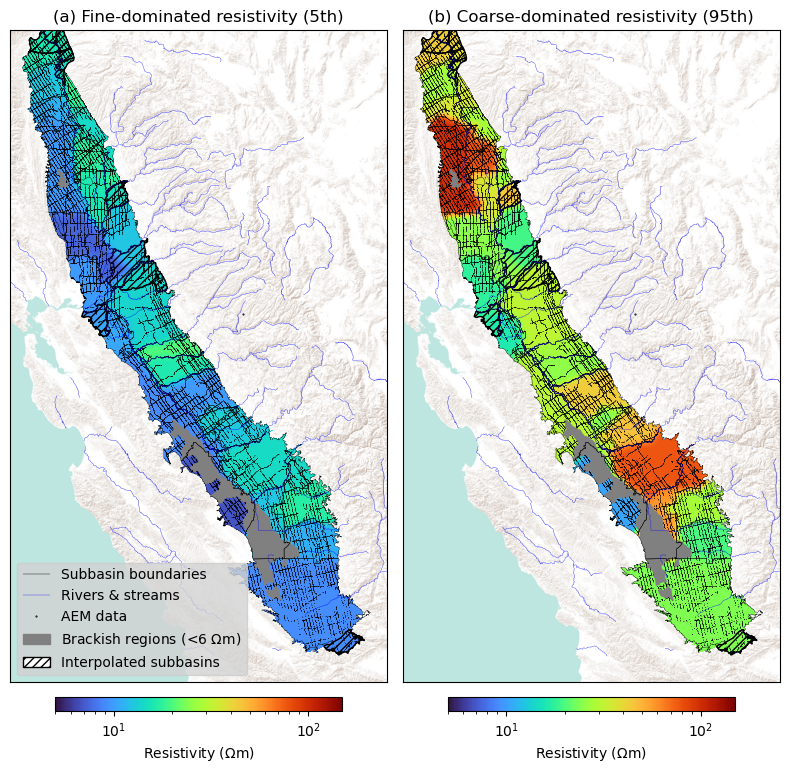

In [ ]:
matplotlib.rcParams['font.size'] = 10
x = [1, 2, 4, 3, 1]
y = [1, 3, 3, 1, 1]
fig, axs = plt.subplots(1,2, figsize=(8, 8))
ax1, ax2 = axs
xlim = (-235738.88808281758, 146356.82349804082)
ylim = (-372488.7201856468, 287608.05395729607)
show(src, ax=ax1, alpha=1)
show(src, ax=ax2, alpha=1)


out = mesh_orig.plot_image(rho_fine_cv_grid_idw_final, ax=ax1, pcolor_opts={'norm':LogNorm(vmin=5, vmax=150), 'cmap':'turbo'})
cb1 = plt.colorbar(out[0], ax=ax1, orientation='horizontal', fraction=0.02, pad=0.02)
out = mesh_orig.plot_image(rho_coarse_cv_grid_idw_final, ax=ax2, pcolor_opts={'norm':LogNorm(vmin=5, vmax=150), 'cmap':'turbo'})
cb2 = plt.colorbar(out[0], ax=ax2, orientation='horizontal', fraction=0.02, pad=0.02)
cb1.set_label("Resistivity ($\Omega$m)")
cb2.set_label("Resistivity ($\Omega$m)")


for ii, ax in enumerate([ax1, ax2]):

    gdf_subbasin_cv.boundary.plot(color='k', linewidth=0.3, ax=ax, label='Subbasin boundaries')
    gdf_basins_3310_cv.set_index('Basin_Su_1',inplace=False).loc[subbasin_names_inactive].plot(ax=ax, color='None', hatch='////')
    gdf_rho_salinity.plot(ax=ax, legend=True, color='grey')
    ax.plot(xy_aem_active[::5,0], xy_aem_active[::5,1], 'k,', alpha=0.3)
    gdf_rivers_3310.plot(color='blue', linewidth=0.3, ax=ax, alpha=0.8, label='Rivers & streams')
    ax.plot(0,0, 'k.', label="AEM data", ms=1)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel("")
    ax.set_ylabel("")
    # ax.axis('off')
    ax.set_aspect(1)
    ax.set_facecolor('lightgrey')
ax1.fill(x, y, color='grey', label='Brackish regions (<6 $\Omega$m)')
ax1.fill_between((0,0), (1,1), color='w', hatch='////', label='Interpolated subbasins', edgecolors='k')
ax1.legend(loc=3, facecolor='lightgrey')
ax1.set_title("(a) Fine-dominated resistivity (5th)")
ax2.set_title("(b) Coarse-dominated resistivity (95th)")
plt.tight_layout()
plt.show()
fig.savefig('../figures/valley_wide_rock_physics.png', dpi=300)

In [161]:
rho_1 = calcluate_vertical_average(rho_int_uniform_simpeg.data, mask_3d_final, mask_inds__active, 10, 0, average_type='harmonic')
rho_2 = calcluate_vertical_average(rho_int_uniform_simpeg.data, mask_3d_final, mask_inds__active, 30, 10, average_type='harmonic')
rho_3 = calcluate_vertical_average(rho_int_uniform_simpeg.data, mask_3d_final, mask_inds__active, 120, 30, average_type='harmonic')
rho_1_avg_final = idw_interpolation(rho_1, w_final, inds_idw_final)
rho_2_avg_final = idw_interpolation(rho_2, w_final, inds_idw_final)
rho_3_avg_final = idw_interpolation(rho_3, w_final, inds_idw_final)

fcd_1 = calcluate_vertical_average(fcd_int_uniform_simpeg.data, mask_3d_final, mask_inds__active, 10, 0, average_type='arithmetic')
fcd_2 = calcluate_vertical_average(fcd_int_uniform_simpeg.data, mask_3d_final, mask_inds__active, 30, 10, average_type='arithmetic')
fcd_3 = calcluate_vertical_average(fcd_int_uniform_simpeg.data, mask_3d_final, mask_inds__active, 120, 30, average_type='arithmetic')
fcd_1_avg_final = idw_interpolation(fcd_1, w_final, inds_idw_final)
fcd_2_avg_final = idw_interpolation(fcd_2, w_final, inds_idw_final)
fcd_3_avg_final = idw_interpolation(fcd_3, w_final, inds_idw_final)

/Users/sgkang09/anaconda3/envs/em_recharge/lib/python3.8/site-packages/discretize/utils/code_utils.py:216: FutureWarning: TensorMesh.vectorCCz has been deprecated, please use TensorMesh.cell_centers_z. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, warn)
/var/folders/4m/sc07bkn154s8jfc7xp164by00000gq/T/ipykernel_42435/916785756.py:13: RuntimeWarning: invalid value encountered in divide
  avg = 1./((1./MOD*HZ).sum(axis=1) / (HZ).sum(axis=1))
/var/folders/4m/sc07bkn154s8jfc7xp164by00000gq/T/ipykernel_42435/916785756.py:11: RuntimeWarning: invalid value encountered in divide
  avg = (MOD*HZ).sum(axis=1) / (HZ).sum(axis=1)


In [169]:
from matplotlib.colors import LinearSegmentedColormap

colors = [(0, 0.5, 0),    # Green
          (1, 1, 1)]    # White
positions = [0, 1]
green_map = LinearSegmentedColormap.from_list("green_white", list(zip(positions, colors)))

colors = [(1, 1, 1),    # Green
          (0, 0.5, 0)]    # White
positions = [0, 1]
green_r_map = LinearSegmentedColormap.from_list("green_white", list(zip(positions, colors)))

# Extract RGB values from the predefined RdBu colormap
cmap = plt.get_cmap('RdBu')

# Create a list of colors by sampling the colormap
colors = [cmap(i) for i in range(cmap.N)]

# Create the custom colormap
custom_rdbu = LinearSegmentedColormap.from_list("custom_rdbu", np.array(colors)[20:-20][::-1])

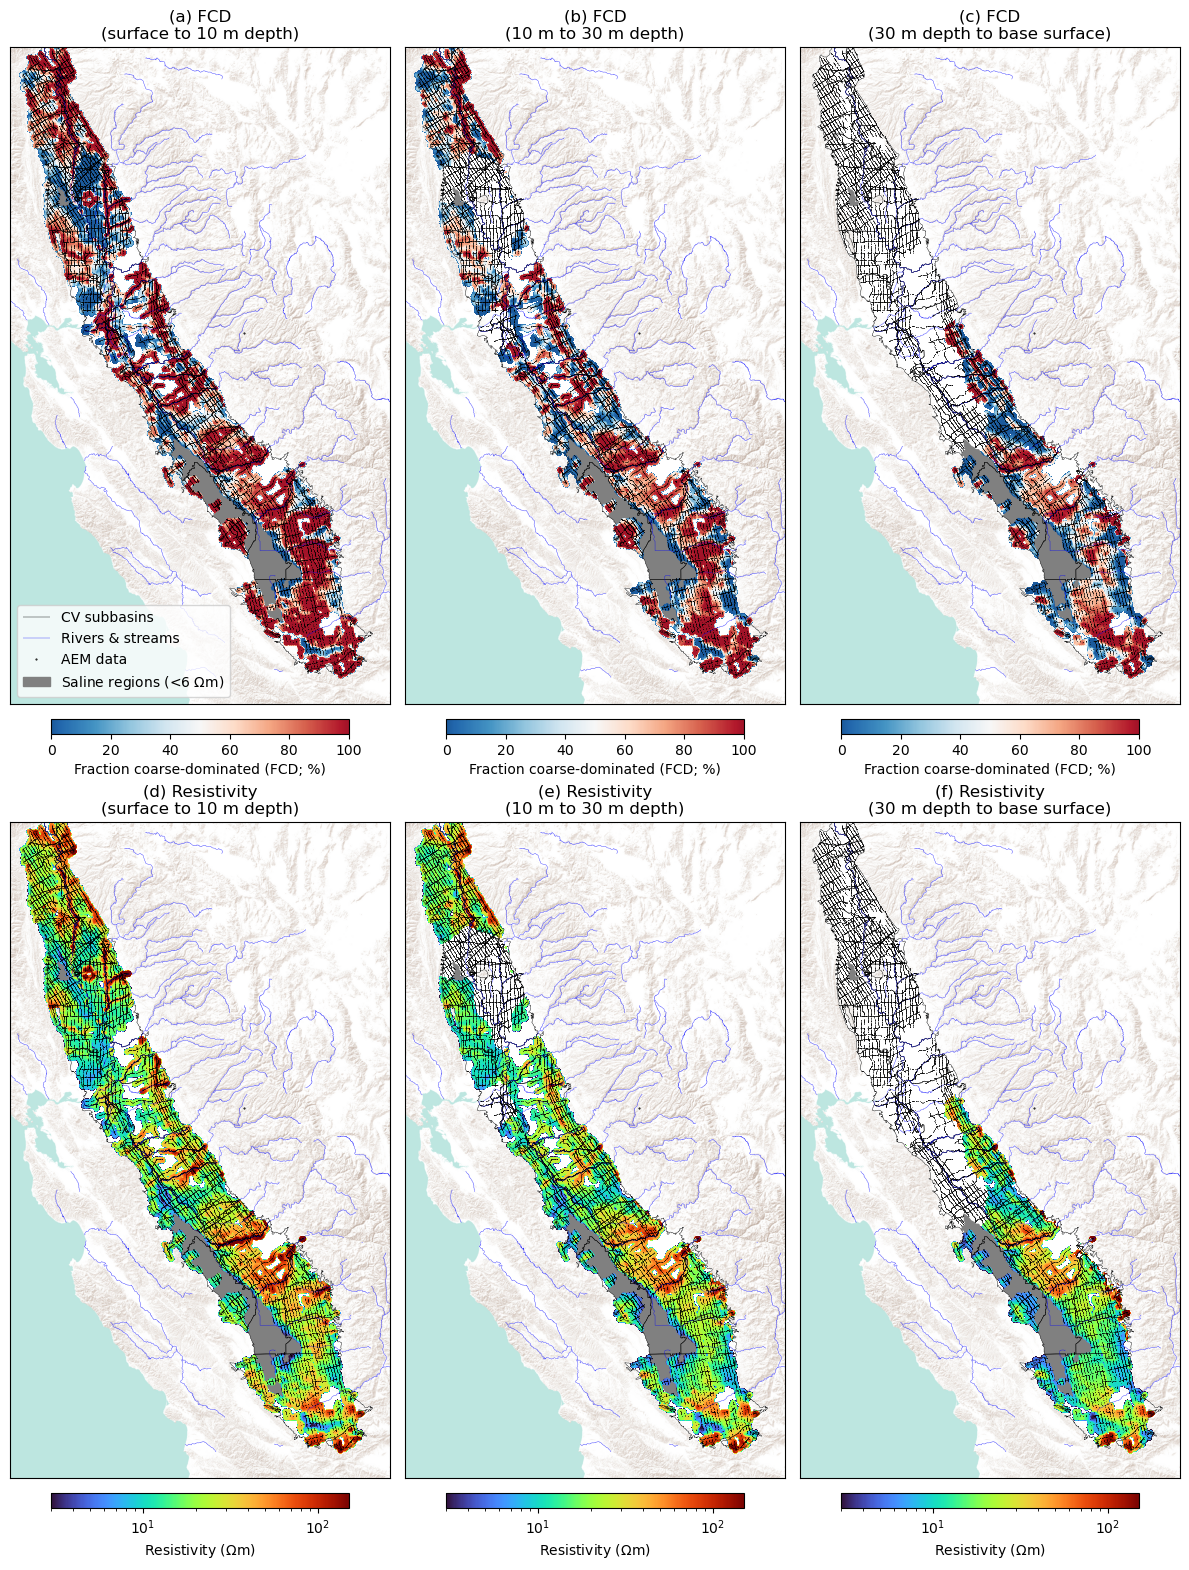

In [ ]:
matplotlib.rcParams['font.size'] = 10

fig, axs = plt.subplots(2,3, figsize=(12, 16))
ax1, ax2, ax3 = axs[0,:]
ax4, ax5, ax6 = axs[1,:]
xlim = (-235738.88808281758, 146356.82349804082)
ylim = (-372488.7201856468, 287608.05395729607)
for tmp in axs:
    for ax in tmp:
        show(src, ax=ax, alpha=1)

out = mesh_orig.plot_image(rho_1_avg_final, ax=ax4, pcolor_opts={'norm':LogNorm(vmin=3, vmax=150), 'cmap':'turbo'})
cb = plt.colorbar(out[0], orientation='horizontal', fraction=0.02, pad=0.02, ax=ax4)
cb.set_label("Resistivity ($\Omega$m)")
ax4.set_title("Resistivity")

out = mesh_orig.plot_image(rho_2_avg_final, ax=ax5, pcolor_opts={'norm':LogNorm(vmin=3, vmax=150), 'cmap':'turbo'})
cb = plt.colorbar(out[0], orientation='horizontal', fraction=0.02, pad=0.02, ax=ax5)
cb.set_label("Resistivity ($\Omega$m)")
ax5.set_title("Resistivity")

out = mesh_orig.plot_image(rho_3_avg_final, ax=ax6, pcolor_opts={'norm':LogNorm(vmin=3, vmax=150), 'cmap':'turbo'})
cb = plt.colorbar(out[0], orientation='horizontal', fraction=0.02, pad=0.02, ax=ax6)
cb.set_label("Resistivity ($\Omega$m)")
ax6.set_title("Resistivity")

out = mesh_orig.plot_image(fcd_1_avg_final*100, ax=ax1, pcolor_opts={'cmap':custom_rdbu})
cb = plt.colorbar(out[0], orientation='horizontal', fraction=0.02, pad=0.02, ax=ax1)
cb.set_label("Fraction coarse-dominated (FCD; %)")
ax1.set_title("FCD")

out = mesh_orig.plot_image(fcd_2_avg_final*100, ax=ax2, pcolor_opts={'cmap':custom_rdbu})
cb = plt.colorbar(out[0], orientation='horizontal', fraction=0.02, pad=0.02, ax=ax2)
cb.set_label("Fraction coarse-dominated (FCD; %)")
ax2.set_title("FCD")

out = mesh_orig.plot_image(fcd_3_avg_final*100, ax=ax3, pcolor_opts={'cmap':custom_rdbu})
cb = plt.colorbar(out[0], orientation='horizontal', fraction=0.02, pad=0.02, ax=ax3)
cb.set_label("Fraction coarse-dominated (FCD; %)")
ax3.set_title("FCD")


for tmp in axs:
    for ax in tmp:
        gdf_subbasin_cv.boundary.plot(color='k', linewidth=0.3, ax=ax, label='CV subbasins')
        gdf_rho_salinity.plot(ax=ax, legend=True, color='grey')
        gdf_rivers_3310.plot(color='blue', linewidth=0.3, ax=ax, alpha=0.8, label='Rivers & streams')
        ax.plot(0,0, 'k.', label="AEM data", ms=1)
        ax.plot(xy_aem_active[::5,0], xy_aem_active[::5,1], 'k,', alpha=0.3)
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel("")
        ax.set_ylabel("")
        # ax.axis('off')
        ax.set_aspect(1)
        ax.set_facecolor('lightgrey')
ax1.fill(x, y, color='grey', label='Saline regions (<6 $\Omega$m)')
ax1.legend(loc=3)
ax1.set_title("(a) FCD\n(surface to 10 m depth)")
ax2.set_title("(b) FCD\n(10 m to 30 m depth)")
ax3.set_title("(c) FCD\n(30 m depth to base surface)")
ax4.set_title("(d) Resistivity\n(surface to 10 m depth)")
ax5.set_title("(e) Resistivity\n(10 m to 30 m depth)")
ax6.set_title("(f) Resistivity\n(30 m depth to base surface)")

plt.tight_layout()
plt.show()
fig.savefig('../figures/2d_rho_fcd_maps.png', dpi=300)


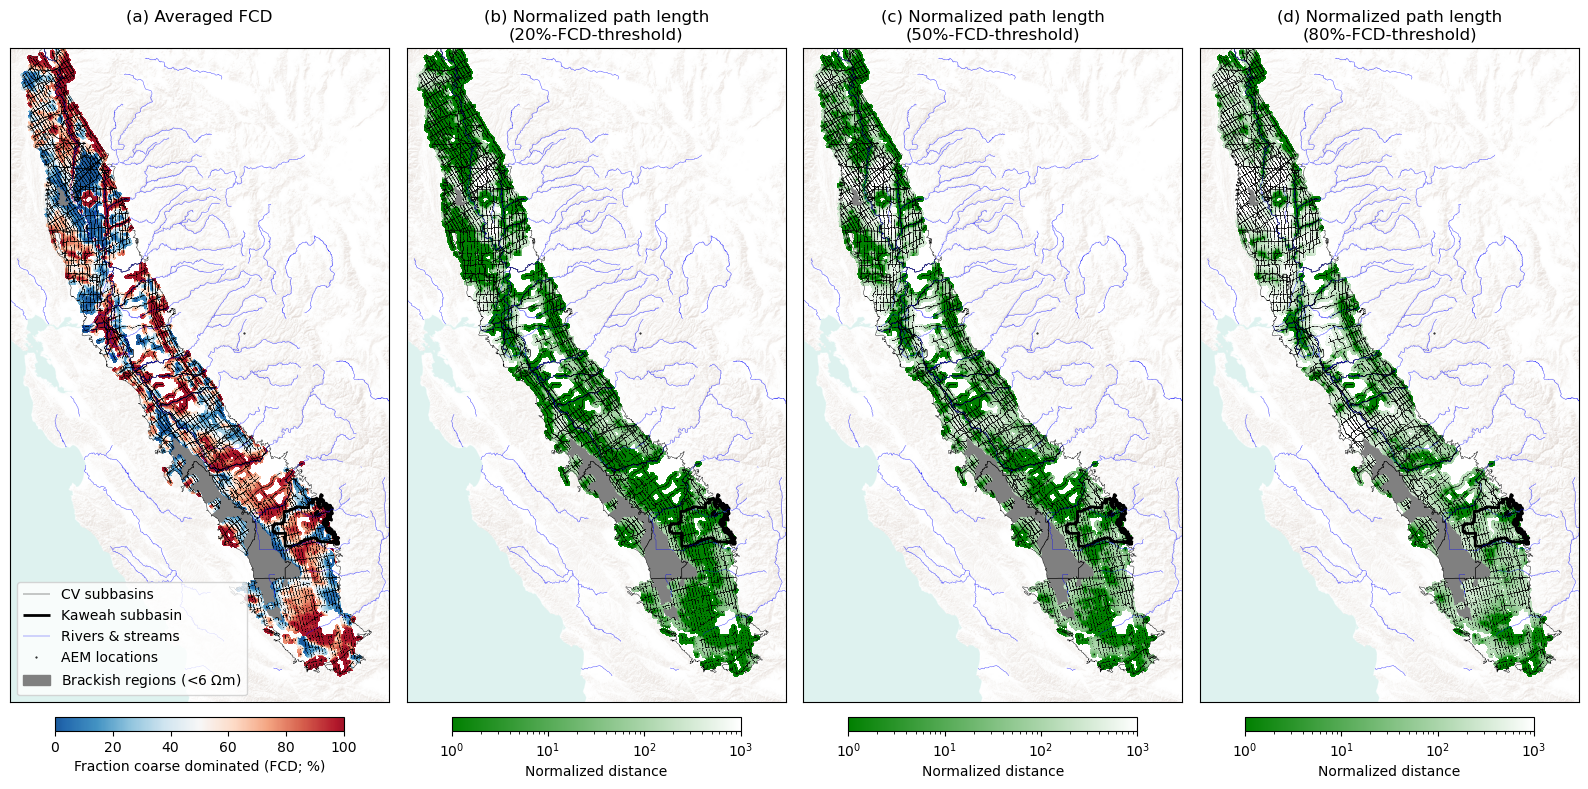

In [ ]:
import matplotlib
matplotlib.rcParams['font.size'] = 10

fig, axs = plt.subplots(1,4, figsize=(16, 8))
ax1, ax2, ax3, ax4 = axs
xlim = (-235738.88808281758, 146356.82349804082)
ylim = (-372488.7201856468, 287608.05395729607)
for ax in axs:
    show(src, ax=ax, alpha=0.5)



out = mesh_orig.plot_image(fc_final*100, ax=ax1, pcolor_opts={'cmap':custom_rdbu})
cb = plt.colorbar(out[0], orientation='horizontal', fraction=0.02, pad=0.02, ax=ax1)
cb.set_label("Fraction coarse dominated (FCD; %)")
ax1.set_title("(a) Averaged FCD\n")

out = mesh_orig.plot_image(path_length_20_norm_final, ax=ax2, pcolor_opts={'cmap':green_map, 'norm':LogNorm(vmin=1, vmax=1000)})
cb = plt.colorbar(out[0], orientation='horizontal', fraction=0.02, pad=0.02, ax=ax2)
cb.set_label("Normalized distance")
ax2.set_title("(b) Normalized path length\n(20%-FCD-threshold)")

out = mesh_orig.plot_image(path_length_30_norm_final, ax=ax3, pcolor_opts={'cmap':green_map, 'norm':LogNorm(vmin=1, vmax=1000)})
cb = plt.colorbar(out[0], orientation='horizontal', fraction=0.02, pad=0.02, ax=ax3)
cb.set_label("Normalized distance")
ax3.set_title("(c) Normalized path length\n(50%-FCD-threshold)")

out = mesh_orig.plot_image(path_length_40_norm_final, ax=ax4, pcolor_opts={'cmap':green_map, 'norm':LogNorm(vmin=1, vmax=1000)})
cb = plt.colorbar(out[0], orientation='horizontal', fraction=0.02, pad=0.02, ax=ax4)
cb.set_label("Normalized distance")
ax4.set_title("(d) Normalized path length\n(80%-FCD-threshold)")



for ax in axs:
    gdf_subbasin_cv.boundary.plot(color='k', linewidth=0.3, ax=ax, label='CV subbasins')
    gdf_subbasin_cv.set_index('Basin_Su_1').loc[['SAN JOAQUIN VALLEY - KAWEAH']].boundary.plot(color='k', label='Kaweah subbasin', ax=ax, linewidth=2)
    gdf_rho_salinity.plot(ax=ax, legend=True, color='grey')
    # gdf_cv_3310.boundary.plot(color='k', linewidth=0.3, ax=ax, label='CV boundary')
    gdf_rivers_3310.plot(color='blue', linewidth=0.3, ax=ax, alpha=0.8, label='Rivers & streams')
    ax.plot(0,0, 'k.', label="AEM locations", ms=1)
    ax.plot(xy_aem_active[::5,0], xy_aem_active[::5,1], 'k,', alpha=0.3)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel("")
    ax.set_ylabel("")
    # ax.axis('off')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_aspect(1)
ax1.fill(x, y, color='grey', label='Brackish regions (<6 $\Omega$m)')
ax1.legend(loc=3)
plt.tight_layout()
plt.show()
fig.savefig('../figures/2d_metric_path_length.png', dpi=300)

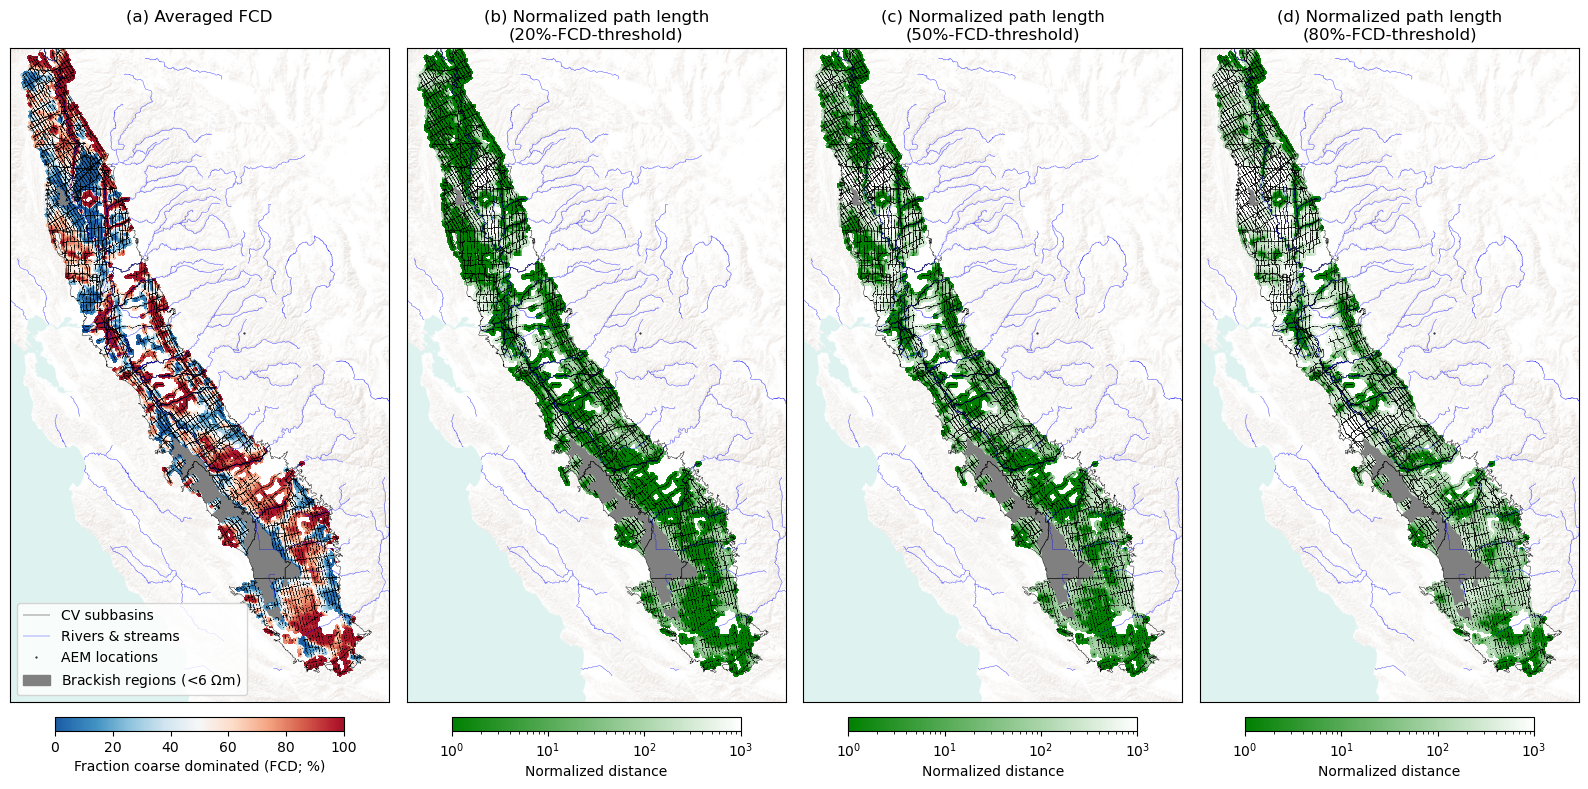

In [ ]:
import matplotlib
matplotlib.rcParams['font.size'] = 10

fig, axs = plt.subplots(1,4, figsize=(16, 8))
ax1, ax2, ax3, ax4 = axs
xlim = (-235738.88808281758, 146356.82349804082)
ylim = (-372488.7201856468, 287608.05395729607)
for ax in axs:
    show(src, ax=ax, alpha=0.5)



out = mesh_orig.plot_image(fc_final*100, ax=ax1, pcolor_opts={'cmap':custom_rdbu})
cb = plt.colorbar(out[0], orientation='horizontal', fraction=0.02, pad=0.02, ax=ax1)
cb.set_label("Fraction coarse dominated (FCD; %)")
ax1.set_title("(a) Averaged FCD\n")

out = mesh_orig.plot_image(path_length_20_norm_final, ax=ax2, pcolor_opts={'cmap':green_map, 'norm':LogNorm(vmin=1, vmax=1000)})
cb = plt.colorbar(out[0], orientation='horizontal', fraction=0.02, pad=0.02, ax=ax2)
cb.set_label("Normalized distance")
ax2.set_title("(b) Normalized path length\n(20%-FCD-threshold)")

out = mesh_orig.plot_image(path_length_30_norm_final, ax=ax3, pcolor_opts={'cmap':green_map, 'norm':LogNorm(vmin=1, vmax=1000)})
cb = plt.colorbar(out[0], orientation='horizontal', fraction=0.02, pad=0.02, ax=ax3)
cb.set_label("Normalized distance")
ax3.set_title("(c) Normalized path length\n(50%-FCD-threshold)")

out = mesh_orig.plot_image(path_length_40_norm_final, ax=ax4, pcolor_opts={'cmap':green_map, 'norm':LogNorm(vmin=1, vmax=1000)})
cb = plt.colorbar(out[0], orientation='horizontal', fraction=0.02, pad=0.02, ax=ax4)
cb.set_label("Normalized distance")
ax4.set_title("(d) Normalized path length\n(80%-FCD-threshold)")



for ax in axs:
    gdf_subbasin_cv.boundary.plot(color='k', linewidth=0.3, ax=ax, label='CV subbasins')
    # gdf_subbasin_cv.set_index('Basin_Su_1').loc[['SAN JOAQUIN VALLEY - KAWEAH']].boundary.plot(color='k', label='Kaweah subbasin', ax=ax, linewidth=2)
    gdf_rho_salinity.plot(ax=ax, legend=True, color='grey')
    # gdf_cv_3310.boundary.plot(color='k', linewidth=0.3, ax=ax, label='CV boundary')
    gdf_rivers_3310.plot(color='blue', linewidth=0.3, ax=ax, alpha=0.8, label='Rivers & streams')
    ax.plot(0,0, 'k.', label="AEM locations", ms=1)
    ax.plot(xy_aem_active[::5,0], xy_aem_active[::5,1], 'k,', alpha=0.3)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel("")
    ax.set_ylabel("")
    # ax.axis('off')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_aspect(1)
ax1.fill(x, y, color='grey', label='Brackish regions (<6 $\Omega$m)')
ax1.legend(loc=3)
plt.tight_layout()
plt.show()
fig.savefig('../figures/2d_metric_path_length_tmp.png', dpi=300)

In [172]:
gdf_kaweah = gdf_subbasin_cv.set_index('Basin_Su_1').loc[['SAN JOAQUIN VALLEY - KAWEAH']]

In [173]:
xmin_kaweah, xmax_kaweah = gdf_kaweah.bounds.values[0][[0,2]]
ymin_kaweah, ymax_kaweah = gdf_kaweah.bounds.values[0][[1,3]]

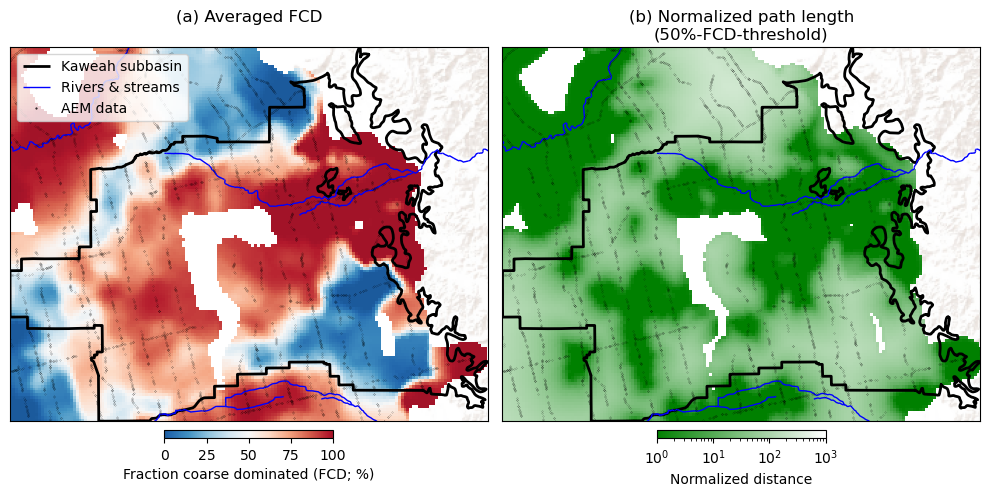

In [ ]:
matplotlib.rcParams['font.size'] = 10
fig, axs = plt.subplots(1,2, figsize=(10, 5))
ax1, ax2 = axs
xlim = (xmin_kaweah, xmax_kaweah)
ylim = (ymin_kaweah, ymax_kaweah)
for ax in axs:
    show(src, ax=ax, alpha=0.5)

out = mesh_orig.plot_image(fc_final*100, ax=ax1, pcolor_opts={'cmap':custom_rdbu})
cb = plt.colorbar(out[0], orientation='horizontal', fraction=0.02, pad=0.02, ax=ax1)
cb.set_label("Fraction coarse dominated (FCD; %)")
ax1.set_title("(a) Averaged FCD\n")

out = mesh_orig.plot_image(path_length_30_norm_final, ax=ax2, pcolor_opts={'cmap':green_map, 'norm':LogNorm(vmin=1, vmax=1000)})
cb = plt.colorbar(out[0], orientation='horizontal', fraction=0.02, pad=0.02, ax=ax2)
cb.set_label("Normalized distance")
ax2.set_title("(b) Normalized path length\n(50%-FCD-threshold)")


for ax in axs:
    # gdf_subbasin_cv.boundary.plot(color='k', linewidth=0.3, ax=ax, label='CV subbasins')
    gdf_subbasin_cv.set_index('Basin_Su_1').loc[['SAN JOAQUIN VALLEY - KAWEAH']].boundary.plot(color='k', label='Kaweah subbasin', ax=ax, linewidth=2)
    # gdf_rho_salinity.plot(ax=ax, legend=True, color='grey')
    # gdf_cv_3310.boundary.plot(color='k', linewidth=0.3, ax=ax, label='CV boundary')
    gdf_rivers_3310.plot(color='blue', linewidth=1, ax=ax, alpha=1, label='Rivers & streams')
    ax.plot(0,0, 'k.', label="AEM data", ms=1)
    ax.plot(xy_aem_active[::5,0], xy_aem_active[::5,1], 'ko', ms=0.1, mfc='k')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel("")
    ax.set_ylabel("")
    # ax.axis('off')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_aspect(1)
ax1.legend(loc=2)
plt.tight_layout()
fig.savefig('../figures/2d_metric_path_length_kaweah.png', dpi=300)

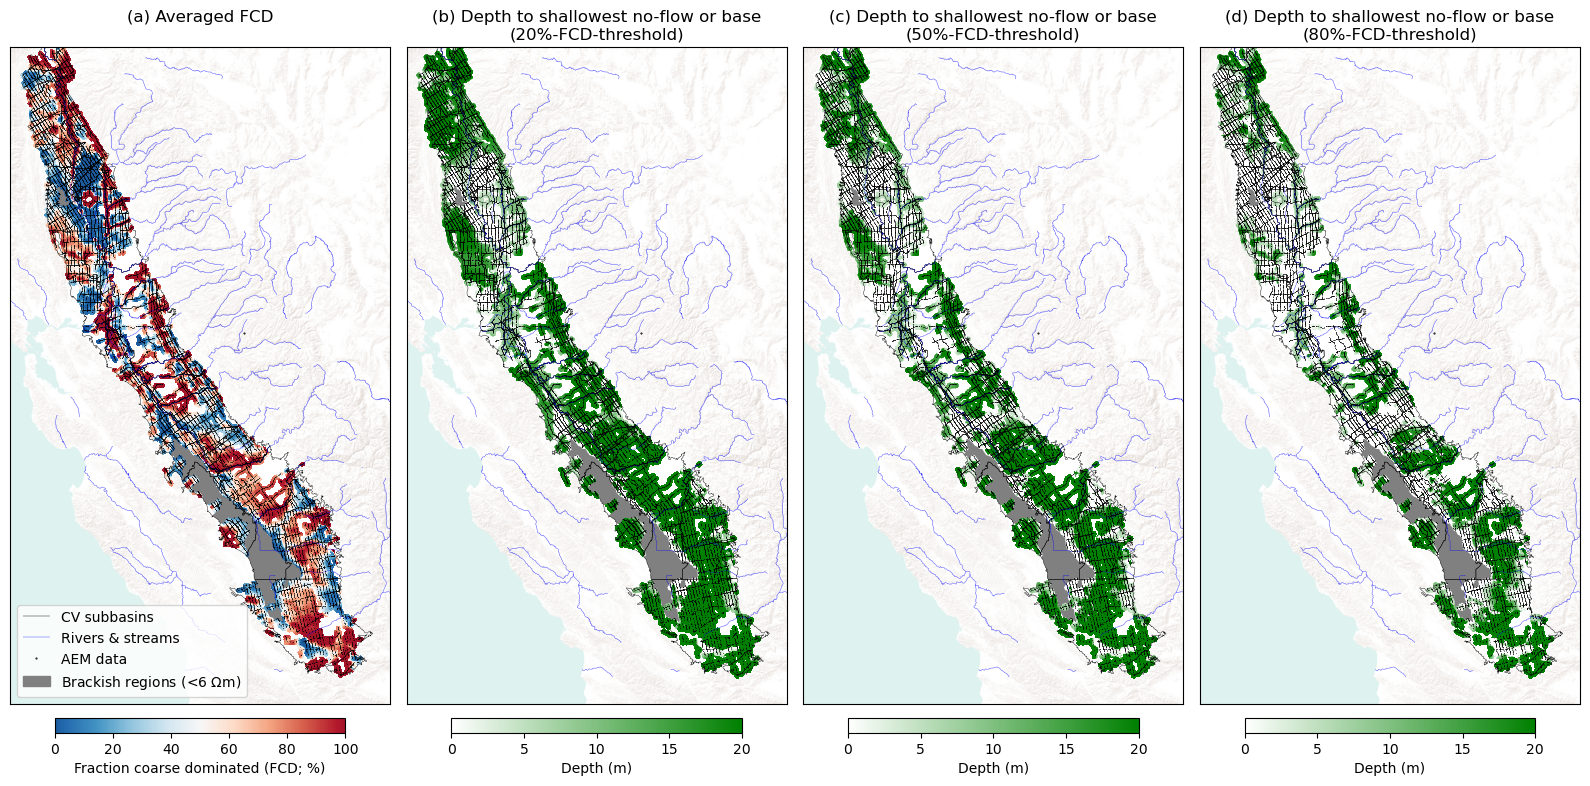

In [ ]:
import matplotlib
matplotlib.rcParams['font.size'] = 10

fig, axs = plt.subplots(1,4, figsize=(16, 8))
ax1, ax2, ax3, ax4 = axs
xlim = (-235738.88808281758, 146356.82349804082)
ylim = (-372488.7201856468, 287608.05395729607)
for ax in axs:
    show(src, ax=ax, alpha=0.5)



out = mesh_orig.plot_image(fc_final*100, ax=ax1, pcolor_opts={'cmap':custom_rdbu})
cb = plt.colorbar(out[0], orientation='horizontal', fraction=0.02, pad=0.02, ax=ax1)
cb.set_label("Fraction coarse dominated (FCD; %)")
ax1.set_title("(a) Averaged FCD\n")

out = mesh_orig.plot_image(path_to_no_flow_20_final, ax=ax2, pcolor_opts={'clim':(0, 20), 'cmap':green_r_map})
cb = plt.colorbar(out[0], orientation='horizontal', fraction=0.02, pad=0.02, ax=ax2)
cb.set_label("Depth (m)")
ax2.set_title("(b) Depth to shallowest no-flow or base\n(20%-FCD-threshold)")

out = mesh_orig.plot_image(path_to_no_flow_30_final, ax=ax3, pcolor_opts={'clim':(0, 20), 'cmap':green_r_map})
cb = plt.colorbar(out[0], orientation='horizontal', fraction=0.02, pad=0.02, ax=ax3)
cb.set_label("Depth (m)")
ax3.set_title("(c) Depth to shallowest no-flow or base\n(50%-FCD-threshold)")

out = mesh_orig.plot_image(path_to_no_flow_40_final, ax=ax4, pcolor_opts={'clim':(0, 20), 'cmap':green_r_map})
cb = plt.colorbar(out[0], orientation='horizontal', fraction=0.02, pad=0.02, ax=ax4)
cb.set_label("Depth (m)")
ax4.set_title("(d) Depth to shallowest no-flow or base\n(80%-FCD-threshold)")



for ax in axs:
    gdf_subbasin_cv.boundary.plot(color='k', linewidth=0.3, ax=ax, label='CV subbasins')
    gdf_rho_salinity.plot(ax=ax, legend=True, color='grey')
    # gdf_cv_3310.boundary.plot(color='k', linewidth=0.3, ax=ax, label='CV boundary')
    gdf_rivers_3310.plot(color='blue', linewidth=0.3, ax=ax, alpha=0.8, label='Rivers & streams')
    ax.plot(0,0, 'k.', label="AEM data", ms=1)
    ax.plot(xy_aem_active[::5,0], xy_aem_active[::5,1], 'k,', alpha=0.3)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel("")
    ax.set_ylabel("")
    # ax.axis('off')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_aspect(1)
ax1.fill(x, y, color='grey', label='Brackish regions (<6 $\Omega$m)')
ax1.legend(loc=3)
plt.tight_layout()
plt.show()
fig.savefig('../figures/2d_metric_depth_to_shallowest.png', dpi=300)

In [176]:
thres_path_length_norm = 50.
thres_path_to_no_flow = 10.
inds_all = np.logical_and(fc_final.data>0.8, path_length_40_norm_final.data<thres_path_length_norm, path_to_no_flow_40_final.data>thres_path_to_no_flow)
final_binary_metric_up = inds_all.astype(float)
final_binary_metric_up = ma.masked_array(data=final_binary_metric_up, mask=fc_final.mask)
inds_all = np.logical_and(fc_final.data>0.5, path_length_30_norm_final.data<thres_path_length_norm, path_to_no_flow_30_final.data>thres_path_to_no_flow)
final_binary_metric_mid = inds_all.astype(float)
final_binary_metric_mid = ma.masked_array(data=final_binary_metric_mid, mask=fc_final.mask)
inds_all = np.logical_and(fc_final.data>0.2, path_length_20_norm_final.data<thres_path_length_norm, path_to_no_flow_20_final.data>thres_path_to_no_flow)
final_binary_metric_low = inds_all.astype(float)
final_binary_metric_low = ma.masked_array(data=final_binary_metric_low, mask=fc_final.mask)

In [208]:
mesh_orig.write_UBC('mesh_orig.msh')

In [ ]:
path_length_norm_list = [
    path_length_10_norm_final,
    path_length_20_norm_final,
    path_length_30_norm_final,
    path_length_40_norm_final,
    path_length_50_norm_final
]

path_to_no_flow_list = [
    path_to_no_flow_10_final,
    path_to_no_flow_20_final,
    path_to_no_flow_30_final,
    path_to_no_flow_40_final,
    path_to_no_flow_50_final
]
fc_thresholds=[0.1, 0.2, 0.5, 0.8, 0.9]
output_dict = {
    'fc':fc_final,
    'fc_thresholds':fc_thresholds,
    'path_length_norm':{},
    'path_to_no_flow':{},
}
for ii, thres in enumerate(fc_thresholds):
    output_dict['path_length_norm'][thres] = path_length_norm_list[ii]
    output_dict['path_to_no_flow'][thres] = path_to_no_flow_list[ii]
dill.dump(output_dict, open('output_metric_maps.pik', 'wb'))

In [241]:
import matplotlib.colors
binary_cmap = matplotlib.colors.ListedColormap(['white', 'green'])

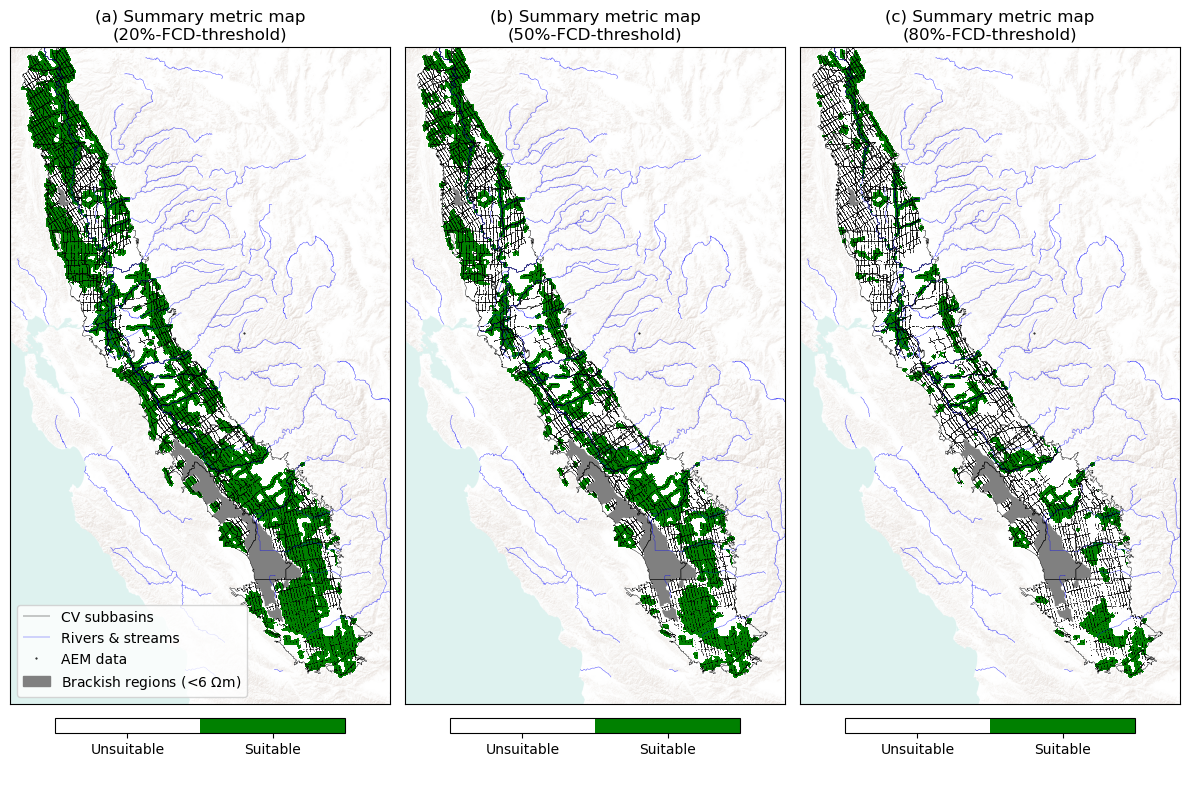

In [ ]:
import matplotlib
matplotlib.rcParams['font.size'] = 10

fig, axs = plt.subplots(1,3, figsize=(12, 8))
ax1, ax2, ax3 = axs
xlim = (-235738.88808281758, 146356.82349804082)
ylim = (-372488.7201856468, 287608.05395729607)
for ax in axs:
    show(src, ax=ax, alpha=0.5)



out = mesh_orig.plot_image(final_binary_metric_low, ax=ax1, pcolor_opts={'clim':(0, 1), 'cmap':binary_cmap})
cb = plt.colorbar(out[0], orientation='horizontal', fraction=0.02, pad=0.02, ax=ax1)
cb.set_ticks([0.25, 0.75])
cb.set_ticklabels(["Unsuitable", "Suitable"])
cb.set_label(" ")
ax1.set_title("(a) Summary metric map\n(20%-FCD-threshold)")

out = mesh_orig.plot_image(final_binary_metric_mid, ax=ax2, pcolor_opts={'clim':(0, 1), 'cmap':binary_cmap})
cb = plt.colorbar(out[0], orientation='horizontal', fraction=0.02, pad=0.02, ax=ax2)
cb.set_ticks([0.25, 0.75])
cb.set_ticklabels(["Unsuitable", "Suitable"])
cb.set_label(" ")
ax2.set_title("(b) Summary metric map\n(50%-FCD-threshold)")


out = mesh_orig.plot_image(final_binary_metric_up, ax=ax3, pcolor_opts={'clim':(0, 1), 'cmap':binary_cmap})
cb = plt.colorbar(out[0], orientation='horizontal', fraction=0.02, pad=0.02, ax=ax3)
cb.set_ticks([0.25, 0.75])
cb.set_ticklabels(["Unsuitable", "Suitable"])
cb.set_label(" ")
ax3.set_title("(c) Summary metric map\n(80%-FCD-threshold)")


for ax in axs:
    gdf_subbasin_cv.boundary.plot(color='k', linewidth=0.3, ax=ax, label='CV subbasins')
    gdf_rho_salinity.plot(ax=ax, legend=True, color='grey')
    # gdf_cv_3310.boundary.plot(color='k', linewidth=0.3, ax=ax, label='CV boundary')
    gdf_rivers_3310.plot(color='blue', linewidth=0.3, ax=ax, alpha=0.8, label='Rivers & streams')
    ax.plot(0,0, 'k.', label="AEM data", ms=1)
    ax.plot(xy_aem_active[::5,0], xy_aem_active[::5,1], 'k,', alpha=0.3)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel("")
    ax.set_ylabel("")
    # ax.axis('off')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_aspect(1)
ax1.fill(x, y, color='grey', label='Brackish regions (<6 $\Omega$m)')
ax1.legend(loc=3)
plt.tight_layout()
plt.show()
fig.savefig('../figures/2d_summary_maps.png', dpi=300)

In [243]:
from emrecharge.gis import export_to_tif

In [244]:
nx = mesh_orig.vnC[0]
ny = mesh_orig.vnC[1]
dx = mesh_orig.h[0][0]
dy = mesh_orig.h[1][0]

xmin = mesh_orig.x0[0]+dx
ymin = mesh_orig.x0[1]+dy
crs = 3310


In [245]:
values = fc_final.data.copy()
values[fc_final.mask] = np.nan
filename = '../metric_maps/cv_fcd_aem'
export_to_tif(values.reshape((nx, ny), order='F').T, dx, dy, xmin, ymin, crs, f'{filename}.tif')

In [246]:
paths = [
    path_length_20_norm_final,
    path_length_30_norm_final,
    path_length_40_norm_final
]
path_to_no_flows = [
    path_to_no_flow_20_final,
    path_to_no_flow_30_final,
    path_to_no_flow_40_final
]
summaries = [
    final_binary_metric_low,
    final_binary_metric_mid,
    final_binary_metric_up,
]
thres_names = ['20', '50', '80']

In [223]:
for ii, path in enumerate(paths):
    values = np.log10(path.data.copy())
    values[path.mask] = np.nan
    filename = '../metric_maps/cv_path_length_aem'
    export_to_tif(values.reshape((nx, ny), order='F').T, dx, dy, xmin, ymin, crs, f'{filename}_{thres_names[ii]}.tif')

In [224]:
for ii, path in enumerate(path_to_no_flows):
    values = path.data.copy()
    values[path.mask] = np.nan
    filename = '../metric_maps/cv_path_to_no_flow_aem'
    export_to_tif(values.reshape((nx, ny), order='F').T, dx, dy, xmin, ymin, crs, f'{filename}_{thres_names[ii]}.tif')

In [225]:
for ii, path in enumerate(summaries):
    values = path.data.copy()
    values[path.mask] = np.nan
    filename = '../metric_maps/cv_summary'
    export_to_tif(values.reshape((nx, ny), order='F').T, dx, dy, xmin, ymin, crs, f'{filename}_{thres_names[ii]}.tif')

In [226]:
values = base_int_final.data.copy()
values[base_int_final.mask] = np.nan
filename = '../metric_maps/cv_base'
export_to_tif(values.reshape((nx, ny), order='F').T, dx, dy, xmin, ymin+dy, crs, f'{filename}.tif')

In [227]:
values = wt_final.data.copy()
values[wt_final.mask] = np.nan
filename = '../metric_maps/cv_wt'
export_to_tif(values.reshape((nx, ny), order='F').T, dx, dy, xmin, ymin+dy, crs, f'{filename}.tif')

In [228]:
values = np.log10(rho_avg_final.data.copy())
values[rho_avg_final.mask] = np.nan
filename = '../metric_maps/cv_rho'
export_to_tif(values.reshape((nx, ny), order='F').T, dx, dy, xmin, ymin, crs, f'{filename}.tif')

In [229]:
values = fcd_1_avg_final.data.copy()
values[rho_avg_final.mask] = np.nan
filename = '../metric_maps/fcd_avg_surface_to_10m'
export_to_tif(values.reshape((nx, ny), order='F').T, dx, dy, xmin, ymin, crs, f'{filename}.tif')

In [230]:
values = fcd_2_avg_final.data.copy()
values[rho_avg_final.mask] = np.nan
filename = '../metric_maps/fcd_avg_10m_to_30m'
export_to_tif(values.reshape((nx, ny), order='F').T, dx, dy, xmin, ymin, crs, f'{filename}.tif')

In [231]:
values = fcd_3_avg_final.data.copy()
values[rho_avg_final.mask] = np.nan
filename = '../metric_maps/fcd_avg_30m_to_base'
export_to_tif(values.reshape((nx, ny), order='F').T, dx, dy, xmin, ymin, crs, f'{filename}.tif')